# Social Network Analysis of Swiss Politicians on Twitter Data
## Tasks
In this assignment you will do the following tasks:
1. Construct the timelines of Twitter users
2. Build social network of retweets
3. Calculate assortativity
4. Permutation tests
5. Community detection

### Install requirements. 

The following cell contains all the necessary dependencies needed for this task. If you run the cell everything will be installed.  

* [`pandas`](https://pandas.pydata.org/docs/index.html) is a Python package for creating and working with tabular data. [Here](https://pandas.pydata.org/docs/reference/index.html) is the documentation of `pandas`.
* [`numpy`](https://numpy.org/) is a Python package for mathematical functions. [Here](https://numpy.org/doc/stable/reference/index.html) is the documentation of `numpy`.
* [`matplotlib`](https://matplotlib.org/) is a Python package for creating plots. [Here](https://matplotlib.org/stable/api/index.html) is the documentation of `matplotlib`.
* [`networkx`](https://networkx.org/) is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks. [Here](https://networkx.org/documentation/stable/reference/index.html) is the documentation of `networkx`.

In [3]:
# ! pip install pandas
# ! pip install numpy
# ! pip install matplotlib
# ! pip install networkx
# ! pip install praw

# # added for zipfile
# ! pip install zipfile36 

### Import requirements
The cell below imports all necessary dependancies. Make sure they are installed (see cell above).

In [4]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timezone
import zipfile # added to open zip-file

# 1. Construct the timelines of Twitter users

You can use the provided `users.csv` file since Twitter API is unavailable at the moment.

**Note:** Since Twitter API is currently unavailable, we also provide a `timelines.csv` file for you that includes tweets from July 5 to July 12. You can find it in the ZIP file, so please unzip it before using.

# 2. Build social networks of retweets

Make sure to first load the timelines and users from the files, parse the creation date as datetime and convert the IDs to strings to avoid int overflows. Use `pandas` [`read_csv`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) to do so. Especially look at the keyword arguments `dtype` and `parse_dates`.

 Since the `referenced_tweets` field contains a list of dictionaries that is stored as a string, we need to parse it first to restore its structure as list of dictionaries to interact with it. For this you can use a combination of pythons [`eval`](https://docs.python.org/3/library/functions.html#eval) function and `pandas` [`apply`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) method. This function takes a string and evaluates it as a python expression. For example if you have following String:
```
some_string_with_a_dict = '{"first_key": "first_value",
                            "second_key": "second_value",
                            "third_key": "third_value",}'
```
And use `eval` on it like the following:
```
usable_dictionary_from_string = eval(some_string_with_a_dict)
```
You get the dictionary as a python local usable dictonary. Try it out!
Now you can convert every `"referenced_tweets"` field in the dataset to usable python expressions.

In [35]:
# Loading timelines zip file
zip_file = zipfile.ZipFile('timelines.zip')

# load timelines and users from file
timelines = pd.read_csv(
    #"timelines.csv",
    zip_file.open("timelines.csv"),
    # dtype={"id":str, "author_id":str, "conversation_id":str}, # load all IDs as string to prevent long integer overflows
    dtype={"id":str},
    parse_dates=["created_at"], # parse the tweet creation date as datetime
    low_memory=False # DtypeWarning: Columns (25,26,28,30,31) have mixed types
)
users = pd.read_csv(
    "users.csv",
    dtype={"id":str, "username":str, "party":str}, # load id, unsername and party as string
    parse_dates=["created_at"]
)

# since the referenced_tweets field contains a list of dictionaries that is 
# stored as a string, we need to parse it first to restore its structure as
# list of dictionaries to interact with it
timelines["referenced_tweets"] = timelines["referenced_tweets"]\
    .apply(lambda x: eval(x) if x == x else np.nan)

# timelines

In [36]:
timelines.loc[0, "referenced_tweets"]

[{'type': 'retweeted',
  'id': '1546388828667006977',
  'reply_settings': 'everyone',
  'conversation_id': '1546388828667006977',
  'author_id': '1391450099205779456',
  'text': 'Am 23. Dezember 1983 fand am @zrh_airport eine PK der El Al statt. Leider wissen wir (noch) nicht mehr über den Inhalt der PK. Wer erkennt Personen auf den Bildern?\nHeute im #Blog #Crowdsourcing #WerWeissMehr\nhttps://t.co/GGIk9ne4KI https://t.co/6OBB5pJQkh',
  'source': 'Twitter Web App',
  'entities': {'mentions': [{'start': 29,
     'end': 41,
     'username': 'zrh_airport',
     'id': '282510542'}],
   'urls': [{'start': 209,
     'end': 232,
     'url': 'https://t.co/GGIk9ne4KI',
     'expanded_url': 'https://doi.org/10.35016/ethz-cs-22047-de',
     'display_url': 'doi.org/10.35016/ethz-…',
     'images': [{'url': 'https://pbs.twimg.com/news_img/1546388847239393282/zpkF2DzQ?format=jpg&name=orig',
       'width': 2000,
       'height': 1000},
      {'url': 'https://pbs.twimg.com/news_img/15463888472393932

The field `referenced_tweets` currently contains a list where each entry is a tweet object (since we requested the expansion on the field `referenced_tweets.id`.

To construct our retweet network, we need to know (a) whether a tweet was a retweet and (b) the ID of the account that posted the tweet that was retweeted. Below we define two functions that help us extract this information from the `referenced_tweets` field:

In [37]:
def check_retweet(entry):
    '''Checks whether a tweet is a retweet'''
    if entry != entry: # NaN check
        return False
    for reference in entry:
        if reference["type"] == "retweeted":
            return True
    return False

def get_retweet_author(entry):
    '''Returns the author ID of the retweeted tweet'''
    if entry != entry: # NaN check
        return np.nan
    for reference in entry:
        if reference["type"] == "retweeted":
            return reference["author_id"]
    return np.nan

Apply the functions `check_retweet()` and `get_retweet_author` to the column `referenced_tweets` and create two new columns `retweeted` and `retweet_user_id` containing the relevant information. Again you can use `pandas` [`apply`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) method.

In [38]:
# Create new column "retweeted" and set it true if Tweet ist retweeted
timelines["retweeted"] = pd.NA # Add empty column

for i in range(len(timelines["referenced_tweets"])):
    result_retweet_check = check_retweet(timelines.loc[i, "referenced_tweets"])
    timelines.loc[i, "retweeted"] = result_retweet_check

In [39]:
# Create new column "retweet_user_id" and fill in retweet author ID if Tweet ist retweeted
timelines["retweet_user_id"] = ""

for i in range(len(timelines["referenced_tweets"])):
    retweet_author = get_retweet_author(timelines.loc[i, "referenced_tweets"])
    timelines.loc[i, "retweet_user_id"] = retweet_author

Filter the tweets in the timelines such that you only retain retweets.

In [40]:
# Filter only Tweet with "retweeted" == TRUE
timelines_with_retweet = timelines.loc[timelines["retweeted"] == True]
# timelines_with_retweet

Now filter the timelines such that the `retweet_user_id` is one of the user IDs in the user list. Use `pandas` [`isin`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isin.html) method for this.

In [41]:
# Read users data
# users = pd.read_csv("users.csv", dtype={"id":str, "username":str, "party":str})
# print(users.head())

# filter timelines witn known users
# timelines_filtered = timelines[timelines["retweet_user_id"].isin(users["id"].astype(str))]
timelines_filtered = timelines[timelines["retweet_user_id"].isin(users["id"])]

#timelines_filtered

Now finaly we can start to create the Graph, start by creating an empty graph with `networkx`. See [here](https://networkx.org/documentation/stable/reference/introduction.html#graph-creation) for more information.

In [42]:
G = nx.Graph()

To build the retweet network, we have to fill the empty graph object we just created with nodes and edges. For this purpose, we prepare a list of nodes and their attributes and a list of edges.

First, construct a list of vertices (nodes) and node attributes containing the user ids,  screen_names, and the **political party label** of the vertices. Remove all users without a party. Each entry of the list has the following form: 

`(id, {"username":username, "party":party})`

Use the function [`add_nodes_from`](https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.add_nodes_from.html) provided by `networkx` to add the nodes to the graph. 

Then build a list of edges where every edge is a pair of two users that exchanged at least one retweet with each other (regardless of the direction, remove all duplicate entries). Each entry of the list has the following form:  

`(author_id_1, author_id_2)`

Use the function [`add_edges_from`](https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.add_edges_from.html) provided by `networkx` to add the edges to the graph.

In [19]:
users.info()
users["party"]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334 entries, 0 to 333
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype              
---  ------                          --------------  -----              
 0   profile_image_url               334 non-null    object             
 1   description                     274 non-null    object             
 2   id                              334 non-null    object             
 3   protected                       334 non-null    bool               
 4   verified                        334 non-null    bool               
 5   username                        334 non-null    object             
 6   location                        241 non-null    object             
 7   url                             196 non-null    object             
 8   pinned_tweet_id                 31 non-null     float64            
 9   name                            334 non-null    object             
 10  created_at    

0       AL
1       AL
2       AL
3       AL
4      BDP
      ... 
329    SVP
330    SVP
331    SVP
332     UP
333     UP
Name: party, Length: 334, dtype: object

In [28]:
users_with_party = users.loc[~users["party"].isna() & (users["party"].str.strip() != "")]
users_with_party = users[users["party"].notna()]
users_with_party

,profile_image_url,description,id,protected,verified,username,location,url,pinned_tweet_id,name,...,public_metrics.followers_count,public_metrics.following_count,public_metrics.tweet_count,public_metrics.listed_count,entities.url.urls,entities.description.mentions,entities.description.urls,entities.description.hashtags,screenName,party
0,https://pbs.twimg.com/profile_images/149375950...,Gemeinderat @al_zuerich. Arbeitet in der @ETHB...,25254764,False,False,andreaskirstein,Zürich,https://t.co/pbzTpZ2ztz,1.180884e+18,Andreas Kirstein,...,743.0,523.0,13640.0,38.0,"[{'start': 0, 'end': 23, 'url': 'https://t.co/...","[{'start': 12, 'end': 23, 'username': 'al_zuer...",NaN,NaN,andreaskirstein,AL
1,https://pbs.twimg.com/profile_images/131178937...,Alt-Gemeinderat Winterthur (Alternative Liste)...,472372843,False,False,bergerwthur,Winterthur,https://t.co/O4Ttdturoi,1.489913e+18,David B. aus W. 📠 🚱🦬✭,...,526.0,376.0,8473.0,17.0,"[{'start': 0, 'end': 23, 'url': 'https://t.co/...",NaN,NaN,NaN,bergerwthur,AL
2,https://pbs.twimg.com/profile_images/378800000...,NaN,1948049047,False,False,maenij,NaN,NaN,NaN,Martin Jucker,...,5.0,21.0,4.0,0.0,NaN,NaN,NaN,NaN,maenij,AL
3,https://pbs.twimg.com/profile_images/143018923...,Seit 2002 Mitglied des Gemeinderats. Leiter Ko...,778497337,False,False,walterangst,Zürich,https://t.co/c2E4fZgf8f,NaN,Walter Angst,...,1042.0,763.0,2052.0,26.0,"[{'start': 0, 'end': 23, 'url': 'https://t.co/...","[{'start': 63, 'end': 74, 'username': 'MV_Zuer...",NaN,NaN,walterangst,AL
4,https://pbs.twimg.com/profile_images/148132495...,Regierungsrätin/Finanzdirektorin,383803341,False,False,asba_j,NaN,NaN,NaN,Astrid Bärtschi,...,1484.0,1456.0,5834.0,53.0,NaN,NaN,NaN,NaN,asba_j,BDP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,https://pbs.twimg.com/profile_images/343740423...,"SVP-Nationalrätin TG, Geschäftsfrau",1307125520,False,False,verenaherzog,Frauenfeld,http://t.co/Bc1h6yzSFq,NaN,Verena Herzog,...,1847.0,908.0,1414.0,106.0,"[{'start': 0, 'end': 22, 'url': 'http://t.co/B...",NaN,NaN,NaN,verenaherzog,SVP
330,https://pbs.twimg.com/profile_images/644400819...,"Seit 1993 in der Schweiz, verheiratet, 1 Kind,...",1017350089,False,False,yvette67yvette,Schweiz,http://t.co/IWhzejR7,NaN,Yvette Estermann,...,1951.0,176.0,578.0,113.0,"[{'start': 0, 'end': 20, 'url': 'http://t.co/I...",NaN,NaN,NaN,yvette67yvette,SVP
331,https://pbs.twimg.com/profile_images/153241242...,"Give me Liberty, or give me Death!\n\nDer Staa...",121068845,False,False,zac1967,"Gossau (ZH), Schweiz",https://t.co/l3p2pWuOnb,1.446920e+18,Claudio Zanetti,...,14881.0,10414.0,156603.0,244.0,"[{'start': 0, 'end': 23, 'url': 'https://t.co/...",NaN,NaN,NaN,zac1967,SVP
332,https://pbs.twimg.com/profile_images/132736255...,"Doch, das kann man schon machen. Jeder der wen...",606601702,False,False,chstampfli,"Zürich, Schweiz",NaN,1.367472e+18,Christoph Stampfli,...,1266.0,608.0,5474.0,29.0,NaN,"[{'start': 95, 'end': 107, 'username': 'HayekC...",NaN,NaN,chstampfli,UP


In [43]:
# Your Code goes here!
nodes = users[["id", "username", "party"]].dropna(subset=["party"])
# Create the node list. Iterate over each row in the nodes dataframe and add the corresponding entry to the list
node_list = [
    (row["id"], {"username": row["username"], "party": row["party"]})
    for _, row in nodes.iterrows()
]

# Add the nodes to the graph
G.add_nodes_from(node_list)

In [44]:
# Your Code goes here!
edges = timelines[["author_id", "retweet_user_id"]].drop_duplicates()

# edges["edge"] = edges.apply(lambda row: tuple(sorted([row["author_id"], row["retweet_user_id"]])), axis=1)

# Create the edge list. Iterate over each row in the edges dataframe and add the corresponding entry to the list
edge_list = [
    (row["author_id"], row["retweet_user_id"])
    for _, row in edges.iterrows()
]

# Add the edges to the graph
G.add_edges_from(edge_list)

Visualize the graph!
Use [`draw_networkx`](https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html) for this.

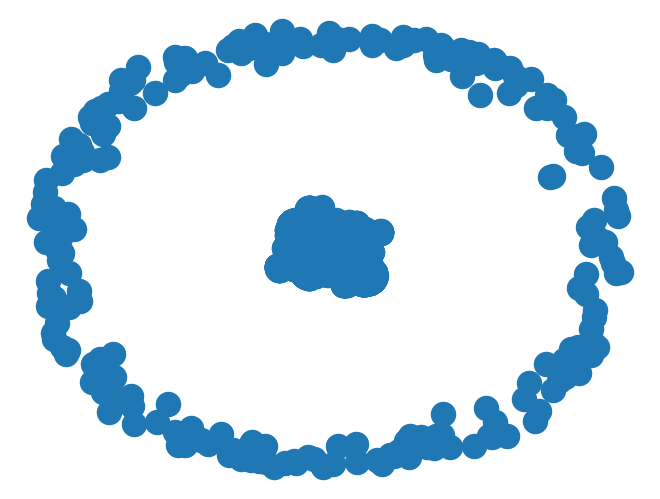

In [47]:
nx.draw(G)

In [33]:
users["party"].unique()

array(['AL', 'BDP', 'CVP', 'EDU', 'EVP', 'FDP', 'GLP', 'Green', 'SP',
       'SVP', 'UP'], dtype=object)

In [45]:
# Your Code goes here!
# Visualization
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)  # Compute layout for positioning

# Draw nodes with colors based on party
party_colors = {
    "AL": "darkred",
    "BDP": "yellow",
    "CVP": "orange",
    "EDU": "darkblue",
    "EVP": "gold",
    "FDP": "blue",
    "GLP": "lightgreen",
    "Green": "green",
    "SP": "red",
    "SVP": "darkgreen",
    "UP": "gray"
}
node_colors = [party_colors[G.nodes[node]["party"]] for node in G.nodes]

nx.draw_networkx(
    G,
    pos,
    with_labels=True,
    node_color=node_colors,
    node_size=500,
    font_size=10,
    font_color="white",
    edge_color="gray"
)

plt.title("Retweet Network")
plt.show()

KeyError: 'party'

<Figure size 800x600 with 0 Axes>

# 3. Calculate graph assortativity

Use the function [`attribute_assortativity_coefficient`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.assortativity.attribute_assortativity_coefficient.html) of `networkx` to calculate the assortativity with respect to party labels. How high is the value?

In [ ]:
# Your Code goes here!


To see if the assortativity value fits your expectations, use the function [`draw_networkx`](https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html) to plot the network coloring each node according to the political party label of the politician. Does the pattern of colors fit the value of assortativity?

Hint 1: use the optional function parameters `nodelist` and `node_color` to pass a list of nodes and a list of corresponding colors to the drawing function.  
Hint 2: you can use one of [matplotlibs categorical color maps](https://matplotlib.org/stable/tutorials/colors/colormaps.html) to get a nice series of distinct colors for the parties. 

In [ ]:
# Your Code goes here!# Your Code goes here!
parties = ... # Get the unique parties frome the nodes dataframe
cmap = ... # Set the color map
colors = ... # Set a color for each unique party
color_dict = ... # Create a Color Dictionary where the keys are the parties and the values are the colors

node_colors = ... # Create a list where each entry is the color of the party for all parties in the nodes dataframe, do not change the order!

In [ ]:
# Plot the graph
fig, ax = plt.subplots()
nx.draw_networkx(
    G, 
    nodelist=nodes["id"],
    node_color=node_colors,
    node_size=10, 
    with_labels=False,
    ax=ax
)
# let's add a legend! Since draw_network does not do this automatically, we have
# to create custom legend elements to add to the plot
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color="w", label=key,
        markerfacecolor=val, markersize=10) for key, val in color_dict.items()]
ax.legend(
    handles=legend_elements, # customly made legend handles
    title="parties", # title of the legend
    loc=1, # anchors the legend in the upper right corner
    bbox_to_anchor=[1.25, 1, 0, 0] # puts the legend outside the plot
);

# 4. Permutation tests

The above result looks assortative, but how can we test if it could have happened at random and not because of party identity? Here were are going to test it with a permutation test.

First, let's run a permutation. Perform the same assortativity calculation as above but permuting the party labels of nodes. You can do this very efficiently by using `pandas` [`sample`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html) function.

Also set the party for each node as node attribute by using [`set_node_attribute`](https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.set_node_attributes.html) (be carefull the parties are now permuted).

In [ ]:
# Your Code goes here!


Is the value much closer to zero?
Repeat the calculation with 1000 permutations and plot the histogram of the resulting values. Add a line with the value of the assortativity without permutation. Is it far or close to the permuted values?

In [ ]:
# Your Code goes here!


In [ ]:
fig, ax = plt.subplots()
ax.hist(...) # Enter the data for the histogram
ax.axvline(...) # Enter the value for the vertical line
ax.set_ylabel("count")
ax.set_xlabel("assortativity")
ax.legend(loc=9)

To be sure, let's calculate a p-value for the null hypothesis that the assortativity is zero and the alternative hypothesis that it is positive (what we expected):

In [ ]:
# Your Code goes here!


After looking at the above results, do you think it is likely that the assortativity we found in the data was produced by chance?

# 5. Community detection

Let's test if Twitter communities match political affiliations. Remove nodes with degree zero in the network and run the [Louvain community detection algorithm](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.louvain.louvain_communities.html). Visualize the result coloring nodes by community labels.

In [ ]:
# Your Code goes here!
import networkx.algorithms.community as nx_comm
G.remove_nodes_from(list(nx.isolates(G)))
communities = ... # Use the louvain algorithm to find communities in the graph 

In [ ]:
# Some coloring
N_communities = len(communities)
cmap = ... # Set the color map
colors = ... # Set a color for each community
color_dict = ... # Create a Color Dictionary where the keys are the communities and the values are the colors

node_list = []
node_colors = []
for i, community in enumerate(communities):
    for node in community:
        node_list.append(node)
        node_colors.append(color_dict[i])

In [ ]:
fig, ax = plt.subplots()
nx.draw_networkx(
    G, 
    nodelist=node_list,
    node_color=node_colors,
    node_size=20, 
    with_labels=False,
    ax=ax
)

# add a legend
legend_elements = [Line2D([0], [0], marker='o', color="w", label=key,
                          markerfacecolor=val, markersize=10) for key, val in color_dict.items()]
ax.legend(
    handles=legend_elements,
    title="communities",
    loc=1, 
    bbox_to_anchor=[1.25, 1, 0, 0]
)

Run the [`modularity`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.quality.modularity.html) function with the above community labels. Is it high enough to think that the network has a community structure?

In [ ]:
# Your Code goes here!


Repeat but using the party labels instead of the communities detected with Louvain. Is it higher or lower? How far is this modularity from the maximal one found with Louvain?

For this iterate over the parties and filter a subset of users that is in the given party and in the graph. Add the ids of these partymembers (do not include any duplicates) and repeat this for all parties.

Afterwards you can calculate the modularity.

In [ ]:
parties = users["party"].unique()
party_communities = []
for party in parties:
    # filter a subset of users that is in the given party and in the graph
    party_members = users[(users["party"] == party) & users["id"].isin(G.nodes)]
    party_communities.append(set(party_members["id"].values))

# Calculate the modularity of the party communities
nx_comm.modularity(G, party_communities)

Finally, to understand which parties are represented in each community, build a data frame for nodes with two columns: one with the party label and another one with the community label. Use the [`groupby()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html) function to print a contingency table. Which party or parties compose each community?

In [ ]:
# Your Code goes here!
# create a copy of the user data frame with all users that are also in the graph
user_communities = ... # create a copy of the user data frame with all users that are also in the graph
user_communities = user_communities.set_index("id") # set the user ID as index
user_communities["community"] = -1 # create a new column for the community assignment (initially set to -1)
for i, community in enumerate(communities):
    # set the community for each user in the community to the community index

# Reset the index and sort by party

# Look at the created dataframe. Which party or parties are in the same community?
# Hint: You can use the .groupby() method to group by a column and then use the .count() method to count the number of entries in each group


# To learn more
* How well can you predict the party of a politician from its neighbors in the network? Here you can use the rule of predicting the party as the majority party among its neighbors and evaluate the accuracy of this approach.
* What would be the results if we use the network of replies? Do you expect assortativity and modularity to be higher or lower?
* If you retrieved data of follower links, you can repeat the above analysis for undirected following relationships. Do you expect a higher or lower assortativity?

## Everything down from here is solved and there is no need to do anything, it's just for curious people that want to see another example of a project in our field

## Reddit

### Data Collection

#### Sign up for the Reddit API
* In this part of the assignment we will collect data using the Reddit API, and compare the tree structure of political and non-political subreddits.
* First, you need to sign up for the Reddit API. For this, follow the steps outlined in [this guide](https://towardsdatascience.com/how-to-use-the-reddit-api-in-python-5e05ddfd1e5c). You will need to create an app on the following [link](https://old.reddit.com/prefs/apps/).
* Next, install the [PRAW package](https://praw.readthedocs.io/en/stable/getting_started/quick_start.html), which provides a nice wrapper for the Reddit API.

#### Collect the data
* Navigate to the following [link](https://www.reddit.com/best/communities/1/) and select 4 political, and 4 non-political subreddits. Ideally, you would want subreddits with around 100-200 thousand members. You want subreddits with enough engagement, but ones which do not typically have a thousand replies to each submission, since the API has a relatively low rate limit.
* Extract the top 20 `hottest` submissions from each of your selected subreddits, ignoring `pinned` submissions.
* For each of the submissions, extract all the comments and replies, and store them, so that you don't need to rerun this step later. Make sure to save the `id`, of the post, the id of its `parent` (the post that it replies to) and the name of the user.

In [ ]:
!pip install python-dotenv

In [ ]:
import praw
import os
from dotenv import load_dotenv
from praw.models import Submission, Comment
from tqdm import tqdm
import json
import pandas as pd

load_dotenv();

In [ ]:
political_subs = ['Liberal', 'AskThe_Donald', 'CapitalismVSocialism']
non_political_subs = ['learnjava', 'PlayItAgainSam', 'Tokyo']

In [ ]:
REDDIT_ID = 'YrwCRAoZnXy5rx3lLRooiQ'#os.getenv("RDT_ID")
REDDIT_SECRET = 'bEBsSPcRnNRatXLz-M2FdU6E1-x4_g' #os.getenv("RDT_SECRET") 
USER_AGENT = 'homework4' # your user agent         

reddit = praw.Reddit(
    client_id=REDDIT_ID,
    client_secret=REDDIT_SECRET,
    user_agent=USER_AGENT
)

In [ ]:
LIMIT = 20

for sub in tqdm(non_political_subs + political_subs):

    results = []
    selected_threads = [submission for submission in reddit.subreddit(sub).hot(limit=LIMIT+5) if not (submission.pinned or submission.stickied)]
    selected_threads = selected_threads[:LIMIT]
    queue = [i for i in selected_threads]

    while queue:

        post = queue.pop(0)
        data = {'name': post.author.name if post.author else 'No author',
                 '_id': post.id, 'parent_id': None}

        if isinstance(post, Submission):
            post.comments.replace_more(limit=0)
            responses = list(post.comments)

        elif isinstance(post, Comment):
            data['parent_id'] = post.parent_id
            post.replies.replace_more(limit=0)
            responses = list(post.replies)

        results.append(data)
        queue.extend(responses)

    with open(f"{sub}.json", "w") as f:
        json.dump(results, f)


###  Analysis
* Create a network/tree for each of the submissions, for this, you may use the [networkx](https://networkx.org/documentation/stable/tutorial.html) package, or create your own classes to store the data.
* For each of the trees, calculate the `maximum depth` and `maximum width`. By maximum depth, we mean the number of edges between the root node, and the furthest leaf node (i.e. the reply which is deepest in the comment tree). The maximum width of the tree is the maximum number of comments, replies on one "level". On the first "level" is the submission itself, on the next one the comments replying directly to the submission, on the third the comments replying to the comments on the first level, and so on.
* Also calculate the `number of nodes` for each of the trees.

In [ ]:
class TreeNode:

    def __init__(self, name, _id, parent):
        self.name = name
        self.id = _id
        self.parent = parent
        self.children = []
    
    def add_child(self, child_name, child_id):
        child_node = TreeNode(child_name, child_id, self)
        self.children.append(child_node)

class Tree:

    def __init__(self, root):
        self.root = root

    def add_node(self, parent_id, child_name, child_id):
        parent = self.find_node(parent_id)
        parent.add_child(child_name, child_id)


    def find_node(self, _id):
        nodes = [self.root]

        _id = _id if '_' not in _id else _id[3:]

        while nodes:
            node = nodes.pop()

            if node.id == _id:
                return node

            nodes.extend(node.children)

    def num_nodes(self):
        nodes = [self.root]
        count = 0

        while nodes:
            node = nodes.pop()
            count += 1
            nodes.extend(node.children)

        return count
    
    def get_leaf_nodes(self):
        nodes = [self.root]
        leaf_nodes = []

        while nodes:
            node = nodes.pop()

            if not node.children:
                leaf_nodes.append(node)
            else:
                nodes.extend(node.children)

        return leaf_nodes
    
    def max_depth(self):

        leaf_nodes = self.get_leaf_nodes()
        max_depth = 0

        for node in leaf_nodes:

            current_node = node
            depth = 0

            while current_node.parent:
                depth += 1
                current_node = current_node.parent

            if depth > max_depth:
                max_depth = depth
        

        return max_depth
    
    def max_width(self):

        max_width = 1

        nodes_on_level = self.root.children

        while nodes_on_level:
            width = len(nodes_on_level)

            if width > max_width:
                max_width = width

            nodes_on_level = [child for node in nodes_on_level for child in node.children]

        return max_width
        



In [ ]:
tree_stats = []

for sub in tqdm(non_political_subs + political_subs):


    with open(f"{sub}.json", "r") as f:
        results = json.load(f)

    root_nodes = [i for i in results if i['parent_id'] is None]

    for root_data in root_nodes:
        res_copy = [i for i in results]
        root = TreeNode(root_data['name'], root_data['_id'], None)
        tree = Tree(root)

        while res_copy:
            node = res_copy.pop(0)

            if node['parent_id'] is None:
                continue
            
            parent = tree.find_node(node['parent_id'])

            if parent:
                parent.add_child(node['name'], node['_id'])

        tree_stats.append({'max_width': tree.max_width(), 'max_depth': tree.max_depth(), 'num_nodes': tree.num_nodes(), 'sub': sub})

    

### Comparison and interpretation
* Compare the mean number of nodes, mean maximum width, and mean maximum depth of political and non-political subreddits. What differences can you notice?
* Can you conduct a statistical test to see if the differences are significant?
* Create a scatterplot with the max depth of the tree on the x-axis, and the max width of the tree on the y-axis. Color the dots based on their group (political vs. non-political). Interpret your results.
* What are the limitations of this analysis? What would you add, or how would you improve it?

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
tree_df = pd.DataFrame(tree_stats)
tree_df['political'] = tree_df['sub'].isin(political_subs)

In [ ]:
tree_df['num_nodes'].sum()

In [ ]:
# import ttest_ind
from scipy.stats import ttest_ind

In [ ]:
political_df = tree_df[tree_df['political'] == True].drop(columns=['political', 'sub']).reset_index(drop=True)
non_political_df = tree_df[tree_df['political'] == False].drop(columns=['political', 'sub']).reset_index(drop=True)

In [ ]:
means_dict = {'max_width': [], 'max_depth': [], 'num_nodes': []}

num_samples = 10_000

for _ in tqdm(range(num_samples)):
    tree_df['random_label'] = tree_df['political'].sample(frac=1).values
    mean_df = tree_df.groupby('random_label').mean(numeric_only=True)
    non_pol_means = mean_df.loc[False]
    pol_means = mean_df.loc[True]
    mean_diff = pol_means - non_pol_means

    for col in means_dict:
        tmp_ls = means_dict[col]
        tmp_ls.append(mean_diff[col])
        means_dict[col] = tmp_ls

means_df = pd.DataFrame(means_dict)

In [ ]:
# plot hist of each column in means_dict
true_means = tree_df.groupby('political').mean(numeric_only=True)
true_means_diff = true_means.loc[True] - true_means.loc[False]
title_dict = {'max_width': 'Tree width', 'max_height': 'Tree height', 'num_nodes': 'Number of nodes'}

for col in means_df.columns:
    plt.hist(means_df[col], bins=25)
    plt.title(col)
    # add vertical line for true mean difference
    plt.axvline(true_means_diff[col], color='red', linestyle='--', label='true value')
    plt.legend()
    plt.show()

In [ ]:
ttest_res = ttest_ind(political_df, non_political_df, equal_var=True)

print("T-Test Results:")

for i, col in enumerate(political_df.columns):
    print(f"{col} -> test statistic: {round(ttest_res.statistic[i], 3)} p-value: {round(ttest_res.pvalue[i], 4)}")

print()
print('Permutation Test Results:')
for col in political_df.columns:
    real_val = true_means_diff[col]
    p_val = (sum(abs(val) > abs(real_val) for val in means_df[col].values) + 1) / len(means_df[col].values)
    print(f"{col} -> p-value: {round(p_val, 4)}")

In [ ]:
# plot relative frequency curve of max width
fig, ax = plt.subplots(figsize=(12, 6))

sns.kdeplot(data=tree_df, x='max_width', hue='political', ax=ax);